## Sections:
* Data import and clean 
* AB test view
* Booking prediction model
* Appendix - Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as cm,roc_curve,auc
from sklearn.preprocessing import FunctionTransformer,PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from datetime import timedelta

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#helper function for plotting roc

def plot_roc(y,y_hat,title_=''):    
    fpr, tpr, thresholds = roc_curve(y,y_hat)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic '+ title_)
    plt.legend(loc="lower right")
    plt.show()

## Import data
* do some conversions
* identify members of control, treatment

In [3]:
# import data
users_raw = pd.read_csv('data/users.csv',header=0)
listings_raw =pd.read_csv('data/listings.csv',header=0)
contacts_raw =pd.read_csv('data/contacts.csv',header=0,date_parser = True)
assignments_raw = pd.read_csv('data/assignments.csv',header=0)#.set_index('id_user_anon')



In [4]:
# convert to datetimes
ts_cols = [i for i in contacts_raw if (i[:2]=='ts')]
ds_cols = [i for i in contacts_raw if i[:2]=='ds']

for i in ts_cols+ds_cols:
    contacts_raw[i]=pd.to_datetime(contacts_raw[i], errors='coerce')

users_raw['ts_first_verified']=pd.to_datetime(users_raw.ts_first_verified,errors='coerce')

In [5]:
# check # of unique user, host, listing contacts
for col in ['id_guest_anon','id_host_anon','id_listing_anon']:
    print col +' unique entries in contacts: '+ str(contacts_raw[col].nunique())




id_guest_anon unique entries in contacts: 25209
id_host_anon unique entries in contacts: 3467
id_listing_anon unique entries in contacts: 5215


In [6]:
# clean up ab table: if user is assigned to more than one group, do not include
assignments = assignments_raw.groupby('id_user_anon').filter(lambda x: len(x)==1)##x.ab.nunique()==1)
assignments.groupby('ab').count()


,id_user_anon
ab,
control,7909
treatment,7849


In [7]:
#add treatment, control to contacts
contacts = pd.merge(contacts_raw, assignments,left_on= 'id_guest_anon',right_on='id_user_anon')

#remove instant book
contacts = contacts[contacts.dim_contact_channel_first!='instant_booked']




## Q1 Define success, see if difference between control, treatment

In [8]:
# define success
contacts["is_booked"] = ((contacts.ts_booking_at-contacts.ts_interaction_first)<timedelta(days=30))*1.0
contacts["accepted"]=((contacts.ts_accepted_at_first-contacts.ts_interaction_first)<timedelta(days=30))*1.0

# per user
#user_level = contacts[['id_guest_anon','ab','is_booked']].groupby(['id_guest_anon','ab']).agg(np.max).reset_index()

In [9]:
# success in group treatment v control
basic_stats = {'avg':np.mean,
              'n':'count',
               'stderr':lambda x: np.std(x)/(len(x)**.5)
               }
aggregation = {'is_booked':basic_stats,'accepted':basic_stats}

contacts.groupby('ab').agg(aggregation)

is_booked                  accepted                
                avg    stderr     n       avg    stderr     n
ab                                                           
control    0.458187  0.005796  7390  0.603383  0.005691  7390
treatment  0.457826  0.005792  7398  0.600297  0.005695  7398

In [10]:
# there are messages with len<140 in the treatment group, this should not be
contacts[contacts.m_first_message_length_in_characters<140].groupby('ab').agg(aggregation)

is_booked                  accepted                
                avg    stderr     n       avg    stderr     n
ab                                                           
control    0.469037  0.011950  1744  0.607225  0.011694  1744
treatment  0.627596  0.018622   674  0.722552  0.017246   674

## Q2 build model to predict successful booking
* construct helper tables, transform function
* test, fit LR model

In [11]:
# take successful to mean trip booked by user, trip defined as anon_id&checkout&checkin are unique



raw_df =contacts_raw
# create trips table, mapping onto listings, hosts, dropping instant books since they ==1 by definition
# the purpose of this table is to determine if a user is sending out multiple messages for the same trip simultaneously
trips = pd.merge(raw_df,listings_raw,on = 'id_listing_anon')
trips = pd.merge(trips,users_raw,left_on='id_guest_anon',right_on='id_user_anon')
trips = pd.merge(trips,users_raw,left_on='id_host_anon',right_on='id_user_anon')
trips['ds_interaction_first']=trips.ts_interaction_first.dt.date
trips=trips[trips.dim_contact_channel_first!='instant_booked']
trips['accepted'] = ((trips.ts_accepted_at_first-trips.ts_interaction_first)<timedelta(days =30))*1.0


# create trips table, break into train,test
y =((trips.ts_booking_at-trips.ts_interaction_first)<timedelta(days =30))*1.0
x_train,x_test,y_train,y_test = train_test_split(trips,y, test_size=0.2, random_state=777)


In [12]:
# build acceptance rate table from training set
# this will be used to normalize for listing and time of year acceptance rates (alternatively use oneHotEncoder)

mu = np.mean(x_train.accepted)

def normalize_acceptance(x):
    return (np.sum(x)+10*mu)/(10+len(x))-mu

accepted_deviance_by_listing = x_train.groupby('id_listing_anon').agg({'accepted':normalize_acceptance}).reset_index()
accepted_deviance_by_listing.columns = ['id_listing_anon','listing_deviance']
accepted_deviance_by_listing.describe()

accepted_deviance_by_toy = x_train.groupby(x_train['ds_checkin_first'].dt.month).\
            agg({'accepted':normalize_acceptance}).reset_index()
accepted_deviance_by_toy.columns=['int_month_booking','time_deviance']

In [13]:
# transformations to construct features

#features: time of year (month of booking, categorical)
#   verified
#   2 hosts contacted, >3; is this not the first host contacted for that date?
#   normalized length of message (log?)
#   speaks english, is american, is canadian, other countries
#   type of booking
#   type of reservation/room_type
#  dim_person_capacity
#   # of ppl on booking
#   capacaity v ppl on booking
#   dim_total_reviews--> log, normalize, is_0
#   m_guests_first, m_interactions
# no bathrooms
# len of stay
# time of day of initial 
# cross terms


# check to see if user is doing multiple bookings, this will help normalize for lower booking rate
# among multi-booker. this data must be extracted from training set, or data available at or near time 
# of booking
trip_id = ['id_guest_anon','ds_interaction_first','ds_checkin_first']
trip_counter =pd.merge(x_train,x_train,how='left',
            on=trip_id).groupby(trip_id).count().reset_index()
trip_counter=trip_counter[trip_id+['id_host_anon_x']]
trip_counter.columns=[trip_id+['num_reqs_sent']]

# create categories
def transform_(df):
    df['int_month_booking']=df.ds_checkin_first.dt.month
    df= pd.merge(df,trip_counter,on=trip_id,how='left')
    df= pd.merge(df,accepted_deviance_by_listing,on='id_listing_anon',how='left')
    df= pd.merge(df,accepted_deviance_by_toy,on='int_month_booking',how='left')
    
    # booleans: types of bookings, matchings
    df['bool_book_it']=1.0*(df.dim_contact_channel_first=='book_it')
    df['bool_match_language']= 1.0*(df.dim_language_x==df.dim_language_y)
    df['bool_match_country']=1.0*(df.dim_country_x==df.dim_country_y)
    df['bool_last_min']=1.0*((df.ds_checkin_first-df.ts_interaction_first)<timedelta(days =7))
    df['bool_home']=(df.dim_room_type== 'Entire home/apt')*1.0
    df['bool_private_room']=1.0*(df.dim_room_type == 'Private room')
    df['bool_verified']=1.0*((df.ts_interaction_first > df.ts_first_verified_x)&(~pd.isnull(df.ts_first_verified_x)))
    
    # relative popularity of listing, time
    df['listing']=df.listing_deviance.fillna(0)
    df['time']=df.time_deviance.fillna(0)
    
    # month of first interaction
    df['int_month_interaction']=df.ts_interaction_first.dt.month
    
    # logarithms of numerical features, with limits for free forms
    df['log_rvws']=np.log1p(df.dim_total_reviews)
    df['log_first_msg']=np.log1p(df.m_first_message_length_in_characters.apply(lambda x: min(x,1000)))
    df['log_num_reqs_sent']=np.log1p(df.num_reqs_sent.fillna(1))
    df['log_guests_first']= np.log1p(df.m_guests_first.fillna(2))
    df['log_length_of_stay']=np.log1p((df.ds_checkout_first-df.ds_checkin_first).apply(lambda x: min(x.days,30)))
    
    output_cats = ['bool_book_it','bool_match_language','bool_match_country',
                  'bool_last_min','bool_home','bool_private_room','bool_verified',
                   'log_rvws','listing','time',
                  'log_first_msg','log_num_reqs_sent','log_guests_first','log_length_of_stay']
                  #'int_month_interaction','int_month_booking']
    return df[output_cats]

/Users/Mikebo/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.850878768441
0.841133004926


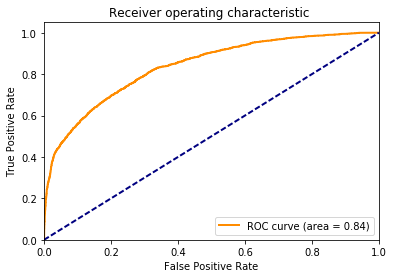

In [25]:
#apply transformations
x_train_=transform_(x_train)
x_test_=transform_(x_test)

# OHE replaced by making difference from means/month a factor
#m=x_train_.shape[1]
#enc=OneHotEncoder(categorical_features=[m-2,m-1],
#    handle_unknown='error', n_values='auto', sparse=False)

poly = PolynomialFeatures()

model = Pipeline([
  #('enc',enc),
    #('ss',StandardScaler()),
  #('poly',poly),
    #('clf',LogisticRegression(C=.01,penalty='l1'))
  ('clf', RandomForestClassifier(n_estimators=100,min_samples_leaf=50))
])

# cross-validation...if I had more time gridsearchcv on (l1,l2),C
# Logistic Regression > RF for ease of interpretability

#fit and score model
model.fit(x_train_,y_train)
print model.score(x_train_,y_train)
print model.score(x_test_,y_test)
plot_roc(y_test,model.predict_proba(x_test_)[:,1])



In [18]:
#use statsmodels to get confidence bands for LR
import statsmodels.discrete.discrete_model as sm

pipe = Pipeline([
    ('ss',StandardScaler()),
      ('poly',poly)
])


target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(x_train_.columns,p) for p in poly.powers_]]
x=pd.DataFrame(data= pipe.fit_transform(x_train_,y_train),columns = target_feature_names)


y=y_train
logit = sm.Logit(y_train.values,x)

alpha =0.01
L1_wt =1

# fit the model
result = logit.fit_regularized(maxiter=10000, 
                               tol=1e-4, 
                               alpha=alpha, 
                               L1_wt=L1_wt, random_state =42)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.356004255405
            Iterations: 1010
            Function evaluations: 1013
            Gradient evaluations: 1010
QC check did not pass for 65 out of 120 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


In [19]:
#book_it,log_rvws,listing,log_first_msg,log_num_reqs_sent
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                38975
Model:                          Logit   Df Residuals:                    38855
Method:                           MLE   Df Model:                          119
Date:                Sun, 02 Apr 2017   Pseudo R-squ.:                  0.3332
Time:                        18:32:47   Log-Likelihood:                -13875.
converged:                       True   LL-Null:                       -20809.
                                        LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
                                              -0.3658        nan        nan        nan         nan         nan
bool_book_it^1                     

In [20]:
# significant factors
sigfacs = (result.pvalues<.05) & (abs(result.params.values)>.1)
sig_model=pd.concat([result.params[sigfacs],result.conf_int()[sigfacs],result.pvalues[sigfacs]],axis=1)
sig_model.columns = ['coef','lb','ub','p']
print 
print 'Significant Coefficients'
sig_model


Significant Coefficients


,coef,lb,ub,p
log_rvws^1,0.391311,0.339576,0.443046,1.013175e-49
listing^1,0.742989,0.689716,0.796262,1.609344e-164
log_first_msg^1,0.179512,0.115864,0.243160,3.241070e-08
log_num_reqs_sent^1,-0.827962,-0.893929,-0.761994,1.279452e-133
bool_book_it^1xlisting^1,0.261458,0.224490,0.298427,1.078041e-43
bool_book_it^1xlog_num_reqs_sent^1,-0.165131,-0.259100,-0.071163,5.726282e-04
bool_home^1xlog_length_of_stay^1,0.325567,0.107642,0.543493,3.410807e-03
bool_private_room^1xlog_length_of_stay^1,0.254736,0.039579,0.469893,2.031360e-02
log_rvws^2,-0.274272,-0.324093,-0.224451,3.842347e-27
log_rvws^1xlisting^1,-0.197660,-0.259626,-0.135693,4.056109e-10


## Appendix: Exploratory Analysis

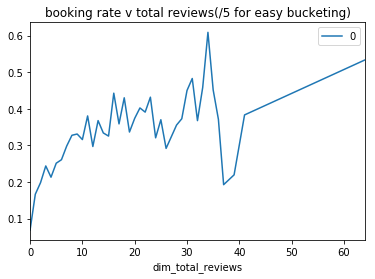

In [21]:
# explore booking vs reviews, seems to be logarithmic increase
pd.concat([x_train.dim_total_reviews,y_train],axis=1).groupby(x_train.dim_total_reviews//5).agg({0:np.mean}).plot()
plt.title('booking rate v total reviews(/5 for easy bucketing)')

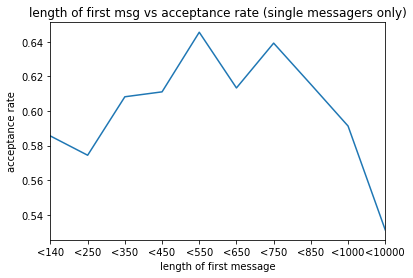

In [22]:
# create length of first msg vs acceptance rate graph
bins = [0, 140, 250,350,450,550,650,750,850,1000, 10000]
group_names = ['<'+str(i) for i in bins[1:]]
contacts['categories'] = pd.cut(contacts.m_first_message_length_in_characters, bins, labels=group_names)

contacts.groupby('categories').agg({'ts_accepted_at_first':{lambda x: np.mean(~pd.isnull(x))}}).reset_index().plot(legend=False)
plt.xticks(range(len(group_names)),group_names);
plt.xlabel('length of first message')
plt.ylabel('acceptance rate')
plt.title('length of first msg vs acceptance rate (single messagers only)')


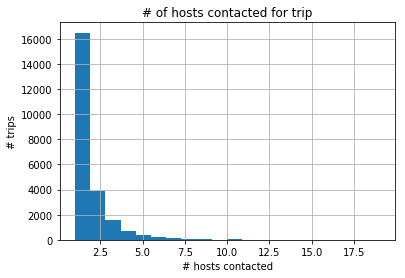

In [23]:
# distribution of attempts per trip
x=x_train.groupby(['id_guest_anon','ds_checkin_first']).count().reset_index()
x[x.id_host_anon<20].id_host_anon.hist(bins=20)
plt.title('# of hosts contacted for trip')
plt.ylabel('# trips')
plt.xlabel('# hosts contacted')

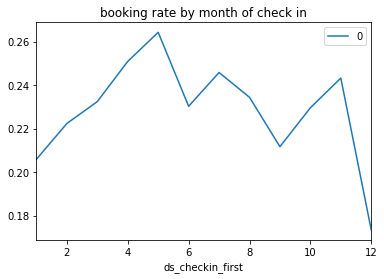

In [24]:
#check for seasonality, in booking rate
pd.concat([x_train['ds_checkin_first'],y_train],axis=1).groupby(x_train['ds_checkin_first'].dt.month).mean().plot()
plt.title('booking rate by month of check in')